# Import necessary packages

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as ss
import re
from bs4 import BeautifulSoup
import sqlite3
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import time

# ====================================
# feel free to import any other package
# ====================================

# 1. NBA Leaders!

The <b><a href="https://global.nba.com/"> NBA official website</a></b> offers the latest news on players, teams, and playoffs for basketball fans. For this task, we'll focus solely on players from the 2024-2025 season. Our plan is to scrape the freely available data from the site and then analyze it statistically.

## 1.1 Crawling Season Leaders Data

Inspect the webpage at https://global.nba.com/statistics/

It contains the top 50 season leaders along with their statistics. The columns in the table represent the following :

* RANK: The player's current ranking
* PLAYER: The player's name
* TEAM: The player's current team
* G: Games played
* GS: Games started
* PPG: Points per game
* RPG: Rebounds per game
* APG: Assists per game
* MPG: Minutes played per game
* EFF: Efficiency rating, a measure of overall statistical contribution
* FG%: Field goal percentage (how often a player makes a shot)
* 3P%: 3-point field goal percentage
* FT%: Free throw percentage
* OFF: Offensive rebounds per game
* DEF: Defensive rebounds per game
* SPG: Steals per game
* BPG: Blocks per game
* TO: Turnovers per game
* PF: Personal fouls per game
* TO: Turnovers per game
* PF: Personal fouls per game
* PO: Points per game

Using the `BeautifulSoup` package, scrape the data from this webpage. You must first scrape and save the data to a Python dictionary. To store the data, you will be using a SQLite database.

In [28]:
def create_sqlite_table(db_file='nba_leaders.db'):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # ========================================================= #
    cursor.execute("DROP TABLE IF EXISTS players")
    table = """CREATE TABLE players (
    RANK INTEGER,
    PLAYER TEXT,
    TEAM TEXT,
    G INTEGER,
    GS INTEGER,
    PPG REAL,
    RPG REAL,
    APG REAL,
    MPG REAL,
    EFF REAL,
    "FG%" REAL,
    "3P%" REAL,
    "FT%" REAL,
    OFF REAL,
    DEF REAL,
    SPG REAL,
    BPG REAL,
    "TO" REAL,
    PF REAL
    );
    """
    cursor.execute(table)
    # ========================================================= #
    
    conn.commit()
    conn.close()


def scrape_nba_data(url):
    # ========================================================= #
    # Set up the Selenium driver (e.g., Chrome)
    C_options = Options()   # Avoiding chrome opening
    C_options.add_argument("--headless")  # Run in headless mode
    C_options.add_argument("--disable-gpu")  # Disable GPU (optional but recommended)
    C_options.add_argument("--no-sandbox")  # Prevent issues on certain systems
    C_options.add_argument("--disable-dev-shm-usage")  # Avoid memory issues in Docker or VMs
    driver = webdriver.Chrome(options=C_options)

    driver.get(url)
    # Wait for loading
    time.sleep(10)
    # cookie agreement
    butt = driver.find_element(By.XPATH,'//button[@class="onetrust-close-btn-handler banner-close-button ot-close-link"]')
    butt.click()
    time.sleep(10)
    page_source = driver.page_source
    soup = BeautifulSoup(page_source, "html.parser")

    # Close the driver after scraping
    driver.quit()
    table = soup.find('tbody')
    nba_stats =[]
    for tr in table.findAll('tr'):  # tr: each player
        text = [text for text in tr.text.splitlines() if text.strip()]
        player_data = { # Assigning data
                "RANK":text[0],
                "PLAYER":text[1] + ' ' + text[2],
                "TEAM":text[3],
                "G":text[4],
                "GS":text[5],
                "PPG":text[6],
                "RPG":text[7],
                "APG":text[8],
                "MPG":text[9],
                "EFF":text[10],
                "FG%": text[11],
                "3P%": text[12],
                "FT%": text[13],
                "OFF": text[14],
                "DEF": text[15],
                "SPG": text[16],
                "BPG": text[17],
                "TO": text[18],
                "PF": text[19],
            }
            # Append the player data dictionary to the list
        nba_stats.append(player_data)
    return nba_stats
    # ========================================================= #


def save_to_sqlite(data, db_file='nba_leaders.db'):
    conn = sqlite3.connect(db_file)

    # ========================================================= #
    df = pd.DataFrame(data)
    df.to_sql('players', conn, if_exists='append', index=False)
    # ========================================================= #
    
    conn.commit()
    conn.close()

url = "https://global.nba.com/statistics/"
data = scrape_nba_data(url)

create_sqlite_table()

save_to_sqlite(data)

conn = sqlite3.connect('nba_leaders.db')
cursor = conn.cursor()
dummy = cursor.execute('''SELECT * FROM players''') 
for row in dummy: 
    print(row)

(1, 'Giannis Antetokounmpo', 'MIL', 11, 11, 33.3, 12.1, 5.5, 35.5, 37.5, 61.6, 22.2, 61.0, 2.3, 9.8, 0.5, 1.4, 2.8, 3.2)
(2, 'Anthony Davis', 'LAL', 10, 10, 30.2, 10.8, 2.8, 34.8, 34.5, 56.0, 40.0, 80.0, 2.1, 8.7, 1.2, 2.1, 2.3, 1.6)
(3, 'Jayson Tatum', 'BOS', 13, 13, 30.2, 7.6, 5.6, 36.1, 30.2, 46.7, 37.8, 81.0, 0.5, 7.2, 1.5, 0.6, 2.9, 2.6)
(4, 'LaMelo Ball', 'CHA', 11, 11, 29.9, 5.0, 6.3, 33.5, 24.6, 44.7, 37.5, 84.9, 1.0, 4.0, 1.4, 0.3, 4.5, 4.0)
(5, 'Nikola Jokić', 'DEN', 10, 10, 29.7, 13.7, 11.7, 38.1, 44.2, 56.3, 56.4, 84.3, 4.5, 9.2, 1.7, 1.0, 4.1, 2.0)
(6, 'Paolo Banchero', 'ORL', 5, 5, 29.0, 8.8, 5.6, 36.4, 28.6, 49.5, 34.4, 64.4, 2.4, 6.4, 0.6, 0.8, 2.2, 2.6)
(7, 'Luka Dončić', 'DAL', 11, 11, 28.5, 8.1, 7.9, 37.9, 27.9, 41.9, 32.1, 79.2, 0.5, 7.6, 1.5, 0.4, 3.3, 3.2)
(8, 'Shai Gilgeous-Alexander', 'OKC', 12, 12, 27.9, 5.5, 6.3, 33.2, 29.2, 49.8, 30.9, 88.9, 0.8, 4.8, 1.8, 1.2, 2.8, 1.7)
(9, 'Anthony Edwards', 'MIN', 12, 12, 27.8, 5.2, 3.8, 36.6, 22.6, 46.2, 42.3, 73.2, 0.4, 

## 1.2 Crawling Players Personal Information

Inspect the webpage at https://global.nba.com/playerindex/

It provides personal information of all the players in the season along with the functionality to filter the players by name.

To be able to filter the players in the webpage, you must perform the scraping using the package `Selenium`.

Create another SQL table named **players_personal_info**. this one and the table in the previous questions must be related via a defined key.

In [37]:
def create_sqlite_table(db_file='players_personal_info.db'):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # ========================================================= # PLAYER:KEY
    cursor.execute("DROP TABLE IF EXISTS players")
    table = """CREATE TABLE players (
    PLAYER TEXT,
    TEAM TEXT,
    POS TEXT,
    HT TEXT,
    WT TEXT,
    EXP INTEGER,
    COUNTRY TEXT
    );
    """
    cursor.execute(table)
    # ========================================================= #
    
    conn.commit()
    conn.close()


def scrape_nba_player_index(url):
    
    # ========================================================= #
    C_options = Options()   # Avoiding chrome opening
    C_options.add_argument("--headless")  # Run in headless mode
    C_options.add_argument("--disable-gpu")  # Disable GPU (optional but recommended)
    C_options.add_argument("--no-sandbox")  # Prevent issues on certain systems
    C_options.add_argument("--disable-dev-shm-usage")  # Avoid memory issues in Docker or VMs
    driver = webdriver.Chrome(options=C_options)

    driver.get(url)
    # Wait for loading
    time.sleep(10)
    # cookie agreement
    butt = driver.find_element(By.XPATH,'//button[@class="onetrust-close-btn-handler banner-close-button ot-close-link"]')
    butt.click()
    time.sleep(10)
    data =[]
    for i in np.arange(0,26):
            #Parse with BeautifulSoup
        if i!= 0:
            butt = driver.find_element(By.XPATH,'//div[@class="active"]/following-sibling::*[1]')
            butt.click()
            time.sleep(3)
        page_source = driver.page_source
        soup = BeautifulSoup(page_source, "html.parser")
        table = soup.find('tbody')
        for tr in table.findAll('tr'):  # each player
            text = [text for text in tr.text.splitlines() if text.strip()]
            # print(text)
            player_data = { # Assigning data
                    "PLAYER":text[-7],
                    "TEAM":text[-6],
                    "POS":text[-5],
                    "HT":text[-4],
                    "WT":text[-3],
                    "EXP":text[-2],
                    "Country":text[-1]
                }
                # Append the player data dictionary to the list
            data.append(player_data)
    driver.quit()
    return data
    # ========================================================= #


def save_to_sqlite(data, db_file='players_personal_info.db'):
    conn = sqlite3.connect(db_file)

    # ========================================================= #
    df = pd.DataFrame(data)
    df.to_sql('players', conn, if_exists='append', index=False)
    # ========================================================= #
    
    conn.commit()
    conn.close()
    
url = 'https://global.nba.com/playerindex/'
# data = scrape_nba_player_index(url)

create_sqlite_table()

save_to_sqlite(data)

conn = sqlite3.connect('players_personal_info.db')
cursor = conn.cursor()
dummy = cursor.execute('''SELECT * FROM players''') 
for row in dummy: 
    print(row)


('Precious Achiuwa', 'NYK', 'F', '6-8', '243 lbs', 4, 'Nigeria')
('Steven Adams', 'HOU', 'C', '6-11', '265 lbs', 10, 'New Zealand')
('Bam Adebayo', 'MIA', 'C-F', '6-9', '255 lbs', 7, 'United States')
('Ochai Agbaji', 'TOR', 'G', '6-5', '215 lbs', 2, 'United States')
('Santi Aldama', 'MEM', 'F-C', '7-0', '215 lbs', 3, 'Spain')
('Trey Alexander', 'DEN', 'G', '6-4', '185 lbs', 0, 'United States')
('Nickeil Alexander-Walker', 'MIN', 'G', '6-5', '205 lbs', 5, 'Canada')
('Grayson Allen', 'PHX', 'G', '6-4', '198 lbs', 6, 'United States')
('Jarrett Allen', 'CLE', 'C', '6-9', '243 lbs', 7, 'United States')
('Jose Alvarado', 'NOP', 'G', '6-0', '179 lbs', 3, 'United States')
('Kyle Anderson', 'GSW', 'F-G', '6-9', '230 lbs', 10, 'United States')
('Giannis Antetokounmpo', 'MIL', 'F', '6-11', '243 lbs', 11, 'Greece')
('Cole Anthony', 'ORL', 'G', '6-2', '185 lbs', 4, 'United States')
('OG Anunoby', 'NYK', 'F-G', '6-7', '240 lbs', 7, 'United Kingdom')
('Deni Avdija', 'POR', 'F', '6-9', '240 lbs', 4, '

## 1.3 Find out the cause!

Next, we'll explore the causal relationships between specific player attributes and their ranking within the top 50. Apply the techniques you learned in class, including propensity score matching, t-tests, and A-B testing, to analyze the following potential causations:

* Does having African heritage contribute to better performance in the NBA?

* Does height cause improved performance in the NBA?

### 1.3.1: African heritage

#### 1.3.1.1: Propensity score

##### 1.3.1.1.1 US as non-African heritage

###### 1.3.1.1.1.1:  Loading

In [9]:
import sqlite3
import pandas as pd

conn_leaders = sqlite3.connect('nba_leaders.db')
nba_leaders = pd.read_sql_query("SELECT * FROM players", conn_leaders)
conn_leaders.close()

conn_info = sqlite3.connect('players_personal_info.db')
players_info = pd.read_sql_query("SELECT * FROM players", conn_info)
conn_info.close()

print(nba_leaders.head())
print(players_info.head())

   RANK                 PLAYER TEAM   G  GS   PPG   RPG   APG   MPG   EFF  \
0     1  Giannis Antetokounmpo  MIL  11  11  33.3  12.1   5.5  35.5  37.5   
1     2          Anthony Davis  LAL  10  10  30.2  10.8   2.8  34.8  34.5   
2     3           Jayson Tatum  BOS  13  13  30.2   7.6   5.6  36.1  30.2   
3     4            LaMelo Ball  CHA  11  11  29.9   5.0   6.3  33.5  24.6   
4     5           Nikola Jokić  DEN  10  10  29.7  13.7  11.7  38.1  44.2   

    FG%   3P%   FT%  OFF  DEF  SPG  BPG   TO   PF  
0  61.6  22.2  61.0  2.3  9.8  0.5  1.4  2.8  3.2  
1  56.0  40.0  80.0  2.1  8.7  1.2  2.1  2.3  1.6  
2  46.7  37.8  81.0  0.5  7.2  1.5  0.6  2.9  2.6  
3  44.7  37.5  84.9  1.0  4.0  1.4  0.3  4.5  4.0  
4  56.3  56.4  84.3  4.5  9.2  1.7  1.0  4.1  2.0  
             PLAYER TEAM  POS    HT       WT  EXP        COUNTRY
0  Precious Achiuwa  NYK    F   6-8  243 lbs    4        Nigeria
1      Steven Adams  HOU    C  6-11  265 lbs   10    New Zealand
2       Bam Adebayo  MIA  C-F 

###### 1.3.1.1.1.2: Merge the Tables

In [10]:
merged_data = pd.merge(nba_leaders, players_info, on='PLAYER', how='inner')

print(merged_data.head())

   RANK                 PLAYER TEAM_x   G  GS   PPG   RPG   APG   MPG   EFF  \
0     1  Giannis Antetokounmpo    MIL  11  11  33.3  12.1   5.5  35.5  37.5   
1     2          Anthony Davis    LAL  10  10  30.2  10.8   2.8  34.8  34.5   
2     3           Jayson Tatum    BOS  13  13  30.2   7.6   5.6  36.1  30.2   
3     4            LaMelo Ball    CHA  11  11  29.9   5.0   6.3  33.5  24.6   
4     5           Nikola Jokić    DEN  10  10  29.7  13.7  11.7  38.1  44.2   

   ...  SPG  BPG   TO   PF  TEAM_y  POS    HT       WT  EXP        COUNTRY  
0  ...  0.5  1.4  2.8  3.2     MIL    F  6-11  243 lbs   11         Greece  
1  ...  1.2  2.1  2.3  1.6     LAL  F-C  6-10  253 lbs   12  United States  
2  ...  1.5  0.6  2.9  2.6     BOS  F-G   6-8  210 lbs    7  United States  
3  ...  1.4  0.3  4.5  4.0     CHA    G   6-7  180 lbs    4  United States  
4  ...  1.7  1.0  4.1  2.0     DEN    C  6-11  284 lbs    9         Serbia  

[5 rows x 25 columns]


###### 1.3.1.1.1.3: African or not?

In [11]:
african_countries = [ #Assuming US as non African
    'Angola','Cameroon','Democratic Republic of Congo',
    'Mali','Nigeria','Senegal','South Sudan','Sudan','Jamaica'
]
# Create binary variable 'African' 
merged_data['African'] = merged_data['COUNTRY'].apply(lambda x: 1 if x in african_countries else 0)

print(merged_data[merged_data['African']==1])


    RANK         PLAYER TEAM_x   G  GS   PPG  RPG  APG   MPG   EFF  ...  BPG  \
41    42  Pascal Siakam    IND  11  11  20.5  6.5  4.3  34.0  23.7  ...  0.2   

     TO   PF  TEAM_y  POS   HT       WT  EXP   COUNTRY African  
41  1.4  2.7     IND    F  6-8  245 lbs    8  Cameroon       1  

[1 rows x 26 columns]


###### 1.3.1.1.1.4: Confounders 

In [12]:
# Height
merged_data['HT'] = merged_data['HT'].str.replace('-', '.', regex=False)
merged_data['HT'] = merged_data['HT'].astype(float)
# Weight
merged_data['WT'] = merged_data['WT'].str.replace(' lbs', '', regex=False)
merged_data['WT'] = merged_data['WT'].astype(float)

###### 1.3.1.1.1.5:  Propensity Score Matching

In [13]:
from statsmodels.api import Logit
from sklearn.neighbors import NearestNeighbors

# Outcome (being in top 50) and confounders
merged_data['top_50'] = merged_data['PLAYER'].isin(nba_leaders['PLAYER']).astype(int)
confounders = ['HT', 'WT', 'EXP'] 

# Propensity scores using logistic regression
ps_model = Logit(merged_data['African'], merged_data[confounders])
ps_model = ps_model.fit()
merged_data['propensity_score'] = ps_model.predict(merged_data[confounders])

# Nearest neighbors matching on propensity score
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
treated = merged_data[merged_data['African'] == 1]
control = merged_data[merged_data['African'] == 0]

nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])
matched_control = control.iloc[indices.flatten()]

# Combine matched treated and control data for analysis
matched_data = pd.concat([treated, matched_control])


Optimization terminated successfully.
         Current function value: 0.100103
         Iterations 8


###### 1.3.1.1.6: Analyze matched pairs 

In [14]:
# Mean
top_50_african = matched_data[matched_data['African'] == 1]['top_50'].mean()
top_50_non_african = matched_data[matched_data['African'] == 0]['top_50'].mean()

print("Mean for African heritage group:", top_50_african)
print("Mean for non-African heritage group:", top_50_non_african)

# Average treatment effect
ate = top_50_african - top_50_non_african
print("Average treatment effect (ATE):", ate)


Mean for African heritage group: 1.0
Mean for non-African heritage group: 1.0
Average treatment effect (ATE): 0.0


##### 1.3.1.1.1: US as African heritage

###### 1.3.1.1.1.1:  Loading

In [15]:
import sqlite3
import pandas as pd

conn_leaders = sqlite3.connect('nba_leaders.db')
nba_leaders = pd.read_sql_query("SELECT * FROM players", conn_leaders)
conn_leaders.close()

conn_info = sqlite3.connect('players_personal_info.db')
players_info = pd.read_sql_query("SELECT * FROM players", conn_info)
conn_info.close()

print(nba_leaders.head())
print(players_info.head())

   RANK                 PLAYER TEAM   G  GS   PPG   RPG   APG   MPG   EFF  \
0     1  Giannis Antetokounmpo  MIL  11  11  33.3  12.1   5.5  35.5  37.5   
1     2          Anthony Davis  LAL  10  10  30.2  10.8   2.8  34.8  34.5   
2     3           Jayson Tatum  BOS  13  13  30.2   7.6   5.6  36.1  30.2   
3     4            LaMelo Ball  CHA  11  11  29.9   5.0   6.3  33.5  24.6   
4     5           Nikola Jokić  DEN  10  10  29.7  13.7  11.7  38.1  44.2   

    FG%   3P%   FT%  OFF  DEF  SPG  BPG   TO   PF  
0  61.6  22.2  61.0  2.3  9.8  0.5  1.4  2.8  3.2  
1  56.0  40.0  80.0  2.1  8.7  1.2  2.1  2.3  1.6  
2  46.7  37.8  81.0  0.5  7.2  1.5  0.6  2.9  2.6  
3  44.7  37.5  84.9  1.0  4.0  1.4  0.3  4.5  4.0  
4  56.3  56.4  84.3  4.5  9.2  1.7  1.0  4.1  2.0  
             PLAYER TEAM  POS    HT       WT  EXP        COUNTRY
0  Precious Achiuwa  NYK    F   6-8  243 lbs    4        Nigeria
1      Steven Adams  HOU    C  6-11  265 lbs   10    New Zealand
2       Bam Adebayo  MIA  C-F 

###### 1.3.1.1.1.2: Merge the Tables

In [16]:
merged_data = pd.merge(nba_leaders, players_info, on='PLAYER', how='inner')

print(merged_data.head())

   RANK                 PLAYER TEAM_x   G  GS   PPG   RPG   APG   MPG   EFF  \
0     1  Giannis Antetokounmpo    MIL  11  11  33.3  12.1   5.5  35.5  37.5   
1     2          Anthony Davis    LAL  10  10  30.2  10.8   2.8  34.8  34.5   
2     3           Jayson Tatum    BOS  13  13  30.2   7.6   5.6  36.1  30.2   
3     4            LaMelo Ball    CHA  11  11  29.9   5.0   6.3  33.5  24.6   
4     5           Nikola Jokić    DEN  10  10  29.7  13.7  11.7  38.1  44.2   

   ...  SPG  BPG   TO   PF  TEAM_y  POS    HT       WT  EXP        COUNTRY  
0  ...  0.5  1.4  2.8  3.2     MIL    F  6-11  243 lbs   11         Greece  
1  ...  1.2  2.1  2.3  1.6     LAL  F-C  6-10  253 lbs   12  United States  
2  ...  1.5  0.6  2.9  2.6     BOS  F-G   6-8  210 lbs    7  United States  
3  ...  1.4  0.3  4.5  4.0     CHA    G   6-7  180 lbs    4  United States  
4  ...  1.7  1.0  4.1  2.0     DEN    C  6-11  284 lbs    9         Serbia  

[5 rows x 25 columns]


###### 1.3.1.1.1.3: African or not?

In [17]:
african_countries = [ #Assuming US as non African
    'Angola','Cameroon','Democratic Republic of Congo','United States',
    'Mali','Nigeria','Senegal','South Sudan','Sudan','Jamaica'
]
# Create binary variable 'African' 
merged_data['African'] = merged_data['COUNTRY'].apply(lambda x: 1 if x in african_countries else 0)

print(merged_data[merged_data['African']==1])


    RANK              PLAYER TEAM_x   G  GS   PPG   RPG   APG   MPG   EFF  \
1      2       Anthony Davis    LAL  10  10  30.2  10.8   2.8  34.8  34.5   
2      3        Jayson Tatum    BOS  13  13  30.2   7.6   5.6  36.1  30.2   
3      4         LaMelo Ball    CHA  11  11  29.9   5.0   6.3  33.5  24.6   
5      6      Paolo Banchero    ORL   5   5  29.0   8.8   5.6  36.4  28.6   
8      9     Anthony Edwards    MIN  12  12  27.8   5.2   3.8  36.6  22.6   
9     10        Kevin Durant    PHX   9   9  27.6   6.6   3.4  38.8  27.4   
10    11        Tyrese Maxey    PHI   7   7  27.6   3.0   3.9  39.7  19.3   
11    12  Karl Anthony Towns    NYK  11  11  26.5  12.2   2.7  33.9  31.7   
12    13      Damian Lillard    MIL  10  10  26.0   4.6   6.6  35.8  25.1   
13    14        Jaylen Brown    BOS   9   9  25.4   7.2   3.7  36.1  22.0   
15    16         Tyler Herro    MIA  10  10  24.9   5.2   5.3  33.5  24.7   
16    17       Norman Powell    LAC  12  12  24.9   3.4   2.6  34.3  21.0   

###### 1.3.1.1.1.4: Confounders 

In [18]:
# Height
merged_data['HT'] = merged_data['HT'].str.replace('-', '.', regex=False)
merged_data['HT'] = merged_data['HT'].astype(float)
# Weight
merged_data['WT'] = merged_data['WT'].str.replace(' lbs', '', regex=False)
merged_data['WT'] = merged_data['WT'].astype(float)

###### 1.3.1.1.1.5:  Propensity Score Matching

In [ ]:
from statsmodels.api import Logit
from sklearn.neighbors import NearestNeighbors

# Outcome (being in top 50) and confounders
merged_data['top_50'] = merged_data['PLAYER'].isin(nba_leaders['PLAYER']).astype(int)
confounders = ['HT', 'WT', 'EXP'] 

# Propensity scores using logistic regression
ps_model = Logit(merged_data['African'], merged_data[confounders])
ps_model = ps_model.fit()
merged_data['propensity_score'] = ps_model.predict(merged_data[confounders])

# Nearest neighbors matching on propensity score
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
treated = merged_data[merged_data['African'] == 1]
control = merged_data[merged_data['African'] == 0]

nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])
matched_control = control.iloc[indices.flatten()]

# Combine matched treated and control data for analysis
matched_data = pd.concat([treated, matched_control])

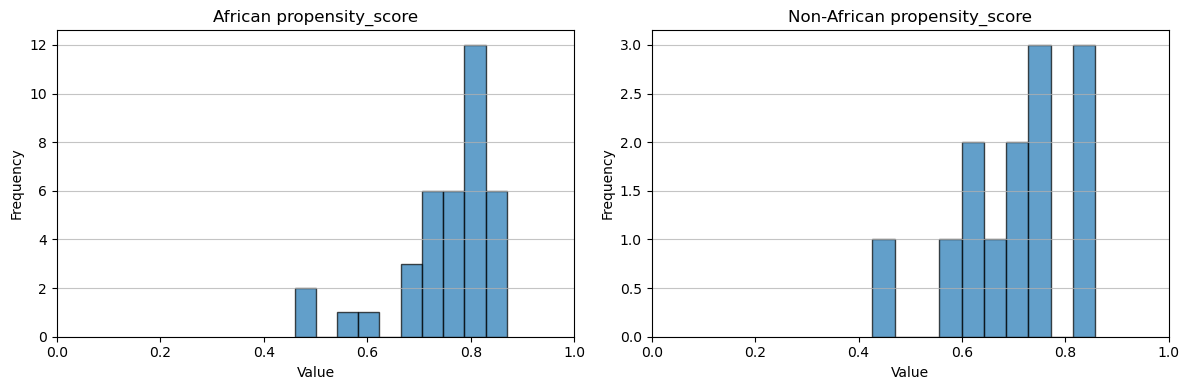

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plotting the first histogram
axs[0].hist(treated['propensity_score'], bins=10, edgecolor='black', alpha=0.7)
axs[0].set_title('African propensity_score')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(0, 1)
axs[0].grid(axis='y', alpha=0.75)

# Plotting the second histogram
axs[1].hist(control['propensity_score'], bins=10, edgecolor='black', alpha=0.7)
axs[1].set_title('Non-African propensity_score')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(0, 1)
axs[1].grid(axis='y', alpha=0.75)

# Show the plot
plt.tight_layout()
plt.show()


###### 1.3.1.1.6: Analyze matched pairs 

In [28]:
# Mean
top_50_african = matched_data[matched_data['top_50'] == 1]['African'].mean()
top_50_non_african = matched_data[matched_data['top_50'] == 0]['African'].mean()

print("Mean for African heritage group:", top_50_african)
print("Mean for non-African heritage group:", top_50_non_african)

# Average treatment effect
ate = top_50_african - top_50_non_african
print("Average treatment effect (ATE):", ate)


Mean for African heritage group: 0.5
Mean for non-African heritage group: nan
Average treatment effect (ATE): nan


#### 1.3.1.2: t-test: US Included

##### 1.3.1.2.1:  Loading

In [29]:
import sqlite3
import pandas as pd

conn_leaders = sqlite3.connect('nba_leaders.db')
nba_leaders = pd.read_sql_query("SELECT * FROM players", conn_leaders)
conn_leaders.close()

conn_info = sqlite3.connect('players_personal_info.db')
players_info = pd.read_sql_query("SELECT * FROM players", conn_info)
conn_info.close()

print(nba_leaders.head())
print(players_info.head())

   RANK                 PLAYER TEAM   G  GS   PPG   RPG   APG   MPG   EFF  \
0     1  Giannis Antetokounmpo  MIL  11  11  33.3  12.1   5.5  35.5  37.5   
1     2          Anthony Davis  LAL  10  10  30.2  10.8   2.8  34.8  34.5   
2     3           Jayson Tatum  BOS  13  13  30.2   7.6   5.6  36.1  30.2   
3     4            LaMelo Ball  CHA  11  11  29.9   5.0   6.3  33.5  24.6   
4     5           Nikola Jokić  DEN  10  10  29.7  13.7  11.7  38.1  44.2   

    FG%   3P%   FT%  OFF  DEF  SPG  BPG   TO   PF  
0  61.6  22.2  61.0  2.3  9.8  0.5  1.4  2.8  3.2  
1  56.0  40.0  80.0  2.1  8.7  1.2  2.1  2.3  1.6  
2  46.7  37.8  81.0  0.5  7.2  1.5  0.6  2.9  2.6  
3  44.7  37.5  84.9  1.0  4.0  1.4  0.3  4.5  4.0  
4  56.3  56.4  84.3  4.5  9.2  1.7  1.0  4.1  2.0  
             PLAYER TEAM  POS    HT       WT  EXP        COUNTRY
0  Precious Achiuwa  NYK    F   6-8  243 lbs    4        Nigeria
1      Steven Adams  HOU    C  6-11  265 lbs   10    New Zealand
2       Bam Adebayo  MIA  C-F 

##### 1.3.1.2.2: Merge the Tables

In [30]:
merged_data = pd.merge(nba_leaders, players_info, on='PLAYER', how='outer')

print(merged_data.head())

   RANK                 PLAYER TEAM_x     G    GS   PPG   RPG   APG   MPG  \
0   1.0  Giannis Antetokounmpo    MIL  11.0  11.0  33.3  12.1   5.5  35.5   
1   2.0          Anthony Davis    LAL  10.0  10.0  30.2  10.8   2.8  34.8   
2   3.0           Jayson Tatum    BOS  13.0  13.0  30.2   7.6   5.6  36.1   
3   4.0            LaMelo Ball    CHA  11.0  11.0  29.9   5.0   6.3  33.5   
4   5.0           Nikola Jokić    DEN  10.0  10.0  29.7  13.7  11.7  38.1   

    EFF  ...  SPG  BPG   TO   PF  TEAM_y  POS    HT       WT  EXP  \
0  37.5  ...  0.5  1.4  2.8  3.2     MIL    F  6-11  243 lbs   11   
1  34.5  ...  1.2  2.1  2.3  1.6     LAL  F-C  6-10  253 lbs   12   
2  30.2  ...  1.5  0.6  2.9  2.6     BOS  F-G   6-8  210 lbs    7   
3  24.6  ...  1.4  0.3  4.5  4.0     CHA    G   6-7  180 lbs    4   
4  44.2  ...  1.7  1.0  4.1  2.0     DEN    C  6-11  284 lbs    9   

         COUNTRY  
0         Greece  
1  United States  
2  United States  
3  United States  
4         Serbia  

[5 rows

##### 1.3.1.2.3: African or not?

In [32]:
african_countries = [ #Assuming US as non African
    'Angola','Cameroon','Democratic Republic of Congo','United States',
    'Mali','Nigeria','Senegal','South Sudan','Sudan','Jamaica'
]
# Create binary variable 'African' 
merged_data['African'] = merged_data['COUNTRY'].apply(lambda x: 1 if x in african_countries else 0)

print(merged_data[merged_data['African']==1])


     RANK           PLAYER TEAM_x     G    GS   PPG   RPG  APG   MPG   EFF  \
1     2.0    Anthony Davis    LAL  10.0  10.0  30.2  10.8  2.8  34.8  34.5   
2     3.0     Jayson Tatum    BOS  13.0  13.0  30.2   7.6  5.6  36.1  30.2   
3     4.0      LaMelo Ball    CHA  11.0  11.0  29.9   5.0  6.3  33.5  24.6   
5     6.0   Paolo Banchero    ORL   5.0   5.0  29.0   8.8  5.6  36.4  28.6   
8     9.0  Anthony Edwards    MIN  12.0  12.0  27.8   5.2  3.8  36.6  22.6   
..    ...              ...    ...   ...   ...   ...   ...  ...   ...   ...   
512   NaN     Jalen Wilson    NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   
513   NaN    James Wiseman    NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   
514   NaN   Christian Wood    NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   
515   NaN     Delon Wright    NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   
517   NaN      Cody Zeller    NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   

     ...  BPG   TO   PF  TEAM_y  POS    HT       WT  EXP       

##### 1.3.1.2.4: Perfoming t-test

In [33]:
from scipy.stats import ttest_ind

merged_data['top_50'] = merged_data['PLAYER'].isin(nba_leaders['PLAYER']).astype(int)
# Split data into two groups based on African heritage
group_african = merged_data[merged_data['African'] == 1]['top_50']
group_non_african = merged_data[merged_data['African'] == 0]['top_50']

# Perform an independent t-test
t_stat, p_value = ttest_ind(group_african, group_non_african, equal_var=False)

# Print the results
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

print("# of top_50 for African heritage players:", group_african.sum())
print("# of top_50 for non-African heritage players:", group_non_african.sum())
print("Total # of African heritage players:", group_african.__len__())
print("Total # of non-African heritage players:", group_non_african.__len__())

T-Statistic: -1.0432036447552817
P-Value: 0.2986388187689363
# of top_50 for African heritage players: 37
# of top_50 for non-African heritage players: 13
Total # of African heritage players: 416
Total # of non-African heritage players: 103


##### 1.3.1.2.5: Interpreting the results

1. **T-Statistic**: `-1.0432`
   - The negative value suggests that the mean probability of being in the top 50 is **lower** for African heritage players compared to non-African heritage players.

2. **P-Value**: `0.299`
   - The p-value is well above the typical significance threshold of `0.05`, meaning that the difference is **not statistically significant**.
   - This suggests that any observed difference in proportions could be due to chance.
   - The lack of statistical significance ($p = 0.299$) means that we cannot confidently conclude that African heritage is associated with a different likelihood of being in the top 50.

3. **Proportions**:
   - **African Heritage Players in Top 50**: $ \frac{37}{416} \approx 8.9\% $
   - **Non-African Heritage Players in Top 50**: $ \frac{13}{103} \approx 12.6\% $

   While the proportion of non-African heritage players in the top 50 is slightly higher, the statistical tests do not indicate a significant difference.


#### 1.3.1.3: A-B testing: US Included 

##### 1.3.1.2.1:  Loading

In [34]:
import sqlite3
import pandas as pd

conn_leaders = sqlite3.connect('nba_leaders.db')
nba_leaders = pd.read_sql_query("SELECT * FROM players", conn_leaders)
conn_leaders.close()

conn_info = sqlite3.connect('players_personal_info.db')
players_info = pd.read_sql_query("SELECT * FROM players", conn_info)
conn_info.close()

print(nba_leaders.head())
print(players_info.head())

   RANK                 PLAYER TEAM   G  GS   PPG   RPG   APG   MPG   EFF  \
0     1  Giannis Antetokounmpo  MIL  11  11  33.3  12.1   5.5  35.5  37.5   
1     2          Anthony Davis  LAL  10  10  30.2  10.8   2.8  34.8  34.5   
2     3           Jayson Tatum  BOS  13  13  30.2   7.6   5.6  36.1  30.2   
3     4            LaMelo Ball  CHA  11  11  29.9   5.0   6.3  33.5  24.6   
4     5           Nikola Jokić  DEN  10  10  29.7  13.7  11.7  38.1  44.2   

    FG%   3P%   FT%  OFF  DEF  SPG  BPG   TO   PF  
0  61.6  22.2  61.0  2.3  9.8  0.5  1.4  2.8  3.2  
1  56.0  40.0  80.0  2.1  8.7  1.2  2.1  2.3  1.6  
2  46.7  37.8  81.0  0.5  7.2  1.5  0.6  2.9  2.6  
3  44.7  37.5  84.9  1.0  4.0  1.4  0.3  4.5  4.0  
4  56.3  56.4  84.3  4.5  9.2  1.7  1.0  4.1  2.0  
             PLAYER TEAM  POS    HT       WT  EXP        COUNTRY
0  Precious Achiuwa  NYK    F   6-8  243 lbs    4        Nigeria
1      Steven Adams  HOU    C  6-11  265 lbs   10    New Zealand
2       Bam Adebayo  MIA  C-F 

##### 1.3.1.2.2: Merge the Tables

In [ ]:
merged_data = pd.merge(nba_leaders, players_info, on='PLAYER', how='outer')

print(merged_data.head())

   RANK                 PLAYER TEAM_x     G    GS   PPG   RPG   APG   MPG  \
0   1.0  Giannis Antetokounmpo    MIL  11.0  11.0  33.3  12.1   5.5  35.5   
1   2.0          Anthony Davis    LAL  10.0  10.0  30.2  10.8   2.8  34.8   
2   3.0           Jayson Tatum    BOS  13.0  13.0  30.2   7.6   5.6  36.1   
3   4.0            LaMelo Ball    CHA  11.0  11.0  29.9   5.0   6.3  33.5   
4   5.0           Nikola Jokić    DEN  10.0  10.0  29.7  13.7  11.7  38.1   

    EFF  ...  SPG  BPG   TO   PF  TEAM_y  POS    HT       WT  EXP  \
0  37.5  ...  0.5  1.4  2.8  3.2     MIL    F  6-11  243 lbs   11   
1  34.5  ...  1.2  2.1  2.3  1.6     LAL  F-C  6-10  253 lbs   12   
2  30.2  ...  1.5  0.6  2.9  2.6     BOS  F-G   6-8  210 lbs    7   
3  24.6  ...  1.4  0.3  4.5  4.0     CHA    G   6-7  180 lbs    4   
4  44.2  ...  1.7  1.0  4.1  2.0     DEN    C  6-11  284 lbs    9   

         COUNTRY  
0         Greece  
1  United States  
2  United States  
3  United States  
4         Serbia  

[5 rows

##### 1.3.1.2.3: African or not?

In [35]:
african_countries = [ #Assuming US as non African
    'Angola','Cameroon','Democratic Republic of Congo','United States',
    'Mali','Nigeria','Senegal','South Sudan','Sudan','Jamaica'
]
# Create binary variable 'African' 
merged_data['African'] = merged_data['COUNTRY'].apply(lambda x: 1 if x in african_countries else 0)

print(merged_data[merged_data['African']==1])


     RANK           PLAYER TEAM_x     G    GS   PPG   RPG  APG   MPG   EFF  \
1     2.0    Anthony Davis    LAL  10.0  10.0  30.2  10.8  2.8  34.8  34.5   
2     3.0     Jayson Tatum    BOS  13.0  13.0  30.2   7.6  5.6  36.1  30.2   
3     4.0      LaMelo Ball    CHA  11.0  11.0  29.9   5.0  6.3  33.5  24.6   
5     6.0   Paolo Banchero    ORL   5.0   5.0  29.0   8.8  5.6  36.4  28.6   
8     9.0  Anthony Edwards    MIN  12.0  12.0  27.8   5.2  3.8  36.6  22.6   
..    ...              ...    ...   ...   ...   ...   ...  ...   ...   ...   
512   NaN     Jalen Wilson    NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   
513   NaN    James Wiseman    NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   
514   NaN   Christian Wood    NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   
515   NaN     Delon Wright    NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   
517   NaN      Cody Zeller    NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   

     ...   TO   PF  TEAM_y  POS    HT       WT  EXP        COUN

##### 1.3.1.3.4: Perfoming A/B-test

**Define Hypotheses**

- **Null Hypothesis (H₀):** There is no difference in the probability of being in the top 50 between players of African heritage and non-African heritage.  
  $
  \mu_{\text{African}} = \mu_{\text{Non-African}}
  $

- **Alternative Hypothesis (H₁):** There is a difference in the probabilities between the two groups.  
  $
  \mu_{\text{African}} \neq \mu_{\text{Non-African}}
  $


In [ ]:
from scipy.stats import ttest_ind

merged_data['top_50'] = merged_data['PLAYER'].isin(nba_leaders['PLAYER']).astype(int)
african_top_50 = len(merged_data[(merged_data['African']==1) & (merged_data['top_50']==1)])
african_total = len(merged_data[merged_data['African']==1])
non_african_top_50 = len(merged_data[(merged_data['African']==0) & (merged_data['top_50']==1)])
non_african_total = len(merged_data[merged_data['African']==0])

# Proportions (probability of being in top 50)
prop_african = african_top_50 / african_total  
prop_non_african = non_african_top_50 / non_african_total  

# Simulate data as binary (1 for top_50, 0 for not_top_50)
african_data = np.concatenate([np.ones(african_top_50), np.zeros(african_total - african_top_50)])
non_african_data = np.concatenate([np.ones(non_african_top_50), np.zeros(non_african_total - non_african_top_50)])

# Perform t-test
t_stat, p_value = ttest_ind(african_data, non_african_data, equal_var=False)  

print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")


T-Statistic: -1.0432036447552817
P-Value: 0.2986388187689363


##### 1.3.1.3.5: Interpreting the results

1. **T-Statistic**: `-1.0432`
   - The negative value indicates that the mean probability of being in the top 50 is **lower** for players of African heritage compared to players of non-African heritage.
   - However, the magnitude of the t-statistic is small, suggesting only a modest difference.

2. **P-Value**: `0.2986`
   - The p-value is much larger than the common significance threshold (\(p < 0.05\)), so the result is **not statistically significant**.
   - This means we fail to reject the null hypothesis, indicating that there is **no evidence of a meaningful difference** in the likelihood of being in the top 50 between the two groups.


### 1.3.2: Height effect

#### 1.3.2.1: Propensity score

##### 1.3.2.1.1:  Loading

In [25]:
import sqlite3
import pandas as pd

conn_leaders = sqlite3.connect('nba_leaders.db')
nba_leaders = pd.read_sql_query("SELECT * FROM players", conn_leaders)
conn_leaders.close()

conn_info = sqlite3.connect('players_personal_info.db')
players_info = pd.read_sql_query("SELECT * FROM players", conn_info)
conn_info.close()

print(nba_leaders.head())
print(players_info.head())

   RANK                 PLAYER TEAM   G  GS   PPG   RPG   APG   MPG   EFF  \
0     1  Giannis Antetokounmpo  MIL  11  11  33.3  12.1   5.5  35.5  37.5   
1     2          Anthony Davis  LAL  10  10  30.2  10.8   2.8  34.8  34.5   
2     3           Jayson Tatum  BOS  13  13  30.2   7.6   5.6  36.1  30.2   
3     4            LaMelo Ball  CHA  11  11  29.9   5.0   6.3  33.5  24.6   
4     5           Nikola Jokić  DEN  10  10  29.7  13.7  11.7  38.1  44.2   

    FG%   3P%   FT%  OFF  DEF  SPG  BPG   TO   PF  
0  61.6  22.2  61.0  2.3  9.8  0.5  1.4  2.8  3.2  
1  56.0  40.0  80.0  2.1  8.7  1.2  2.1  2.3  1.6  
2  46.7  37.8  81.0  0.5  7.2  1.5  0.6  2.9  2.6  
3  44.7  37.5  84.9  1.0  4.0  1.4  0.3  4.5  4.0  
4  56.3  56.4  84.3  4.5  9.2  1.7  1.0  4.1  2.0  
             PLAYER TEAM  POS    HT       WT  EXP        COUNTRY
0  Precious Achiuwa  NYK    F   6-8  243 lbs    4        Nigeria
1      Steven Adams  HOU    C  6-11  265 lbs   10    New Zealand
2       Bam Adebayo  MIA  C-F 

##### 1.3.2.1.2: Merge the Tables

In [26]:
merged_data = pd.merge(nba_leaders, players_info, on='PLAYER', how='outer')

print(merged_data.head())

   RANK                 PLAYER TEAM_x     G    GS   PPG   RPG   APG   MPG  \
0   1.0  Giannis Antetokounmpo    MIL  11.0  11.0  33.3  12.1   5.5  35.5   
1   2.0          Anthony Davis    LAL  10.0  10.0  30.2  10.8   2.8  34.8   
2   3.0           Jayson Tatum    BOS  13.0  13.0  30.2   7.6   5.6  36.1   
3   4.0            LaMelo Ball    CHA  11.0  11.0  29.9   5.0   6.3  33.5   
4   5.0           Nikola Jokić    DEN  10.0  10.0  29.7  13.7  11.7  38.1   

    EFF  ...  SPG  BPG   TO   PF  TEAM_y  POS    HT       WT  EXP  \
0  37.5  ...  0.5  1.4  2.8  3.2     MIL    F  6-11  243 lbs   11   
1  34.5  ...  1.2  2.1  2.3  1.6     LAL  F-C  6-10  253 lbs   12   
2  30.2  ...  1.5  0.6  2.9  2.6     BOS  F-G   6-8  210 lbs    7   
3  24.6  ...  1.4  0.3  4.5  4.0     CHA    G   6-7  180 lbs    4   
4  44.2  ...  1.7  1.0  4.1  2.0     DEN    C  6-11  284 lbs    9   

         COUNTRY  
0         Greece  
1  United States  
2  United States  
3  United States  
4         Serbia  

[5 rows

##### 1.3.2.1.3: Binary Treatment Variable for Height + Preprocess

In [28]:
from scipy.stats import ttest_ind
# Preprocess
# Height
merged_data['HT'] = merged_data['HT'].str.replace('-', '.', regex=False)
merged_data['HT'] = pd.to_numeric(merged_data['HT'], errors='coerce')  # Convert to numeric, setting non-numeric values to NaN
merged_data = merged_data.dropna(subset=['HT']) 
merged_data['HT'] = merged_data['HT'].astype(float)
# Weight
merged_data['WT'] = merged_data['WT'].str.replace(' lbs', '', regex=False)
merged_data['WT'] = merged_data['WT'].astype(float)
merged_data = merged_data.dropna(subset=['HT']) 
merged_data['HT'] = merged_data['HT'].astype(float)
merged_data['top_50'] = merged_data['PLAYER'].isin(nba_leaders['PLAYER']).astype(int)

In [29]:
mean = merged_data['HT'].mean()
merged_data['tall'] = (merged_data['HT'] >= mean).astype(int)

##### 1.3.2.1.4: Estimate Propensity Scores

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Define treatment and confounders
X = merged_data[['EXP', 'WT']]  # Confounders
y = merged_data['tall']  # Treatment variable

# Logistic regression to estimate propensity scores
log_reg = LogisticRegression()
log_reg.fit(X, y)

# Add propensity scores to the DataFrame
merged_data['propensity_score'] = log_reg.predict_proba(X)[:, 1]


##### 1.3.2.1.5: Perform Matching

In [31]:
from sklearn.neighbors import NearestNeighbors

# Separate treated (tall) and control (short) groups
treated = merged_data[merged_data['tall'] == 1]
control = merged_data[merged_data['tall'] == 0]

# Nearest neighbor matching based on propensity scores
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Get matched controls
matched_control = control.iloc[indices.flatten()]

# Combine treated and matched controls
matched_data = pd.concat([treated, matched_control])


##### 1.3.2.1.6: Analyze the Matched Data

In [32]:
from scipy.stats import ttest_ind

# Outcome variable: top_50
top_50_treated = matched_data[matched_data['tall'] == 1]['top_50']
top_50_control = matched_data[matched_data['tall'] == 0]['top_50']

# Perform t-test
t_stat, p_value = ttest_ind(top_50_treated, top_50_control, equal_var=False)

# Print results
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")
print(f"Mean Top 50 Rate (Tall): {top_50_treated.mean()}")
print(f"Mean Top 50 Rate (Short): {top_50_control.mean()}")


T-Statistic: -0.48813677587508436
P-Value: 0.6256687681367705
Mean Top 50 Rate (Tall): 0.076
Mean Top 50 Rate (Short): 0.088


##### 1.3.2.1.7: Interpreting the results

   - **Results**:
      - **T-Statistic**: `-0.4881`
      - **P-Value**: `0.6257`
      - **Mean Top 50 Rate (Tall)**: `0.076`
      - **Mean Top 50 Rate (Short)**: `0.088`

   - **Interpretation**:
      - The p-value (\(p = 0.6257\)) is much greater than 0.05, indicating that the difference in the likelihood of being in the top 50 between tall and short players is **not statistically significant**.
      - The small difference in mean top 50 rates (0.076 for tall vs. 0.088 for short) further supports this conclusion.

   - **Conclusion**:
      - After controlling for confounders using PSM, height does not appear to have a meaningful effect on the likelihood of being in the top 50 players.
      - These results suggest that height alone is not a significant factor in determining top player performance.


#### 1.3.2.2: t-test

##### 1.3.2.2.1:  Loading

In [15]:
import sqlite3
import pandas as pd

conn_leaders = sqlite3.connect('nba_leaders.db')
nba_leaders = pd.read_sql_query("SELECT * FROM players", conn_leaders)
conn_leaders.close()

conn_info = sqlite3.connect('players_personal_info.db')
players_info = pd.read_sql_query("SELECT * FROM players", conn_info)
conn_info.close()

print(nba_leaders.head())
print(players_info.head())

   RANK                 PLAYER TEAM   G  GS   PPG   RPG   APG   MPG   EFF  \
0     1  Giannis Antetokounmpo  MIL  11  11  33.3  12.1   5.5  35.5  37.5   
1     2          Anthony Davis  LAL  10  10  30.2  10.8   2.8  34.8  34.5   
2     3           Jayson Tatum  BOS  13  13  30.2   7.6   5.6  36.1  30.2   
3     4            LaMelo Ball  CHA  11  11  29.9   5.0   6.3  33.5  24.6   
4     5           Nikola Jokić  DEN  10  10  29.7  13.7  11.7  38.1  44.2   

    FG%   3P%   FT%  OFF  DEF  SPG  BPG   TO   PF  
0  61.6  22.2  61.0  2.3  9.8  0.5  1.4  2.8  3.2  
1  56.0  40.0  80.0  2.1  8.7  1.2  2.1  2.3  1.6  
2  46.7  37.8  81.0  0.5  7.2  1.5  0.6  2.9  2.6  
3  44.7  37.5  84.9  1.0  4.0  1.4  0.3  4.5  4.0  
4  56.3  56.4  84.3  4.5  9.2  1.7  1.0  4.1  2.0  
             PLAYER TEAM  POS    HT       WT  EXP        COUNTRY
0  Precious Achiuwa  NYK    F   6-8  243 lbs    4        Nigeria
1      Steven Adams  HOU    C  6-11  265 lbs   10    New Zealand
2       Bam Adebayo  MIA  C-F 

##### 1.3.2.2.2: Merge the Tables

In [16]:
merged_data = pd.merge(nba_leaders, players_info, on='PLAYER', how='outer')

print(merged_data.head())

   RANK                 PLAYER TEAM_x     G    GS   PPG   RPG   APG   MPG  \
0   1.0  Giannis Antetokounmpo    MIL  11.0  11.0  33.3  12.1   5.5  35.5   
1   2.0          Anthony Davis    LAL  10.0  10.0  30.2  10.8   2.8  34.8   
2   3.0           Jayson Tatum    BOS  13.0  13.0  30.2   7.6   5.6  36.1   
3   4.0            LaMelo Ball    CHA  11.0  11.0  29.9   5.0   6.3  33.5   
4   5.0           Nikola Jokić    DEN  10.0  10.0  29.7  13.7  11.7  38.1   

    EFF  ...  SPG  BPG   TO   PF  TEAM_y  POS    HT       WT  EXP  \
0  37.5  ...  0.5  1.4  2.8  3.2     MIL    F  6-11  243 lbs   11   
1  34.5  ...  1.2  2.1  2.3  1.6     LAL  F-C  6-10  253 lbs   12   
2  30.2  ...  1.5  0.6  2.9  2.6     BOS  F-G   6-8  210 lbs    7   
3  24.6  ...  1.4  0.3  4.5  4.0     CHA    G   6-7  180 lbs    4   
4  44.2  ...  1.7  1.0  4.1  2.0     DEN    C  6-11  284 lbs    9   

         COUNTRY  
0         Greece  
1  United States  
2  United States  
3  United States  
4         Serbia  

[5 rows

##### 1.3.2.2.3: Perfoming t-test

In [ ]:
from scipy.stats import ttest_ind
# Preprocess
merged_data['HT'] = merged_data['HT'].str.replace('-', '.', regex=False)
merged_data['HT'] = pd.to_numeric(merged_data['HT'], errors='coerce')  # Convert to numeric, setting non-numeric values to NaN
merged_data = merged_data.dropna(subset=['HT']) 
merged_data['HT'] = merged_data['HT'].astype(float)
merged_data['top_50'] = merged_data['PLAYER'].isin(nba_leaders['PLAYER']).astype(int)

In [ ]:
top_50_height = merged_data[merged_data['top_50'] == 1]['HT']  # Heights of top 50 players
not_top_50_height = merged_data[merged_data['top_50'] == 0]['HT']  # Heights of non-top 50 players

# Perform t-test
t_stat, p_value = ttest_ind(top_50_height, not_top_50_height, equal_var=False)  

# Print results
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")
print(f"mean of top_50_height: {top_50_height.mean()}")
print(f"mean of not_top_50_height: {not_top_50_height.mean()}")

T-Statistic: -2.266000168762958
P-Value: 0.02705397134057544
mean of top_50_height: 6.440600000000001
mean of top_50_height: 6.538972162740899


##### 1.3.2.3.5: Interpreting the results

1. **Hypotheses**:
   - **Null Hypothesis (H₀):** There is no difference in height between players in the top 50 and those not in the top 50.
   - **Alternative Hypothesis (H₁):** There is a difference in height between players in the top 50 and those not in the top 50.

2. **Results**:
   - **T-Statistic**: `-2.266`
   - **P-Value**: `0.0271`
   - **Mean Height of Top 50 Players**: `6.44`
   - **Mean Height of Non-Top 50 Players**: `6.54`

3. **Interpretation**:
   - The p-value (\(p = 0.0271\)) is **less than 0.05**, indicating that the difference in height between the two groups is statistically significant.
   - The negative t-statistic indicates that players in the top 50 are, on average, **shorter** than players not in the top 50.

4. **Summary**:
   - While the difference in height is statistically significant, the actual difference in mean height is relatively small (approximately `0.10` units). This suggests that height may not be a major factor in determining whether a player is in the top 50.

#### 1.3.2.3: A/B testing(Identical to t-test)

##### 1.3.2.3.1:  Loading

In [9]:
import sqlite3
import pandas as pd

conn_leaders = sqlite3.connect('nba_leaders.db')
nba_leaders = pd.read_sql_query("SELECT * FROM players", conn_leaders)
conn_leaders.close()

conn_info = sqlite3.connect('players_personal_info.db')
players_info = pd.read_sql_query("SELECT * FROM players", conn_info)
conn_info.close()

print(nba_leaders.head())
print(players_info.head())

   RANK                 PLAYER TEAM   G  GS   PPG   RPG   APG   MPG   EFF  \
0     1  Giannis Antetokounmpo  MIL  11  11  33.3  12.1   5.5  35.5  37.5   
1     2          Anthony Davis  LAL  10  10  30.2  10.8   2.8  34.8  34.5   
2     3           Jayson Tatum  BOS  13  13  30.2   7.6   5.6  36.1  30.2   
3     4            LaMelo Ball  CHA  11  11  29.9   5.0   6.3  33.5  24.6   
4     5           Nikola Jokić  DEN  10  10  29.7  13.7  11.7  38.1  44.2   

    FG%   3P%   FT%  OFF  DEF  SPG  BPG   TO   PF  
0  61.6  22.2  61.0  2.3  9.8  0.5  1.4  2.8  3.2  
1  56.0  40.0  80.0  2.1  8.7  1.2  2.1  2.3  1.6  
2  46.7  37.8  81.0  0.5  7.2  1.5  0.6  2.9  2.6  
3  44.7  37.5  84.9  1.0  4.0  1.4  0.3  4.5  4.0  
4  56.3  56.4  84.3  4.5  9.2  1.7  1.0  4.1  2.0  
             PLAYER TEAM  POS    HT       WT  EXP        COUNTRY
0  Precious Achiuwa  NYK    F   6-8  243 lbs    4        Nigeria
1      Steven Adams  HOU    C  6-11  265 lbs   10    New Zealand
2       Bam Adebayo  MIA  C-F 

##### 1.3.2.3.2: Merge the Tables

In [10]:
merged_data = pd.merge(nba_leaders, players_info, on='PLAYER', how='outer')

print(merged_data.head())

   RANK                 PLAYER TEAM_x     G    GS   PPG   RPG   APG   MPG  \
0   1.0  Giannis Antetokounmpo    MIL  11.0  11.0  33.3  12.1   5.5  35.5   
1   2.0          Anthony Davis    LAL  10.0  10.0  30.2  10.8   2.8  34.8   
2   3.0           Jayson Tatum    BOS  13.0  13.0  30.2   7.6   5.6  36.1   
3   4.0            LaMelo Ball    CHA  11.0  11.0  29.9   5.0   6.3  33.5   
4   5.0           Nikola Jokić    DEN  10.0  10.0  29.7  13.7  11.7  38.1   

    EFF  ...  SPG  BPG   TO   PF  TEAM_y  POS    HT       WT  EXP  \
0  37.5  ...  0.5  1.4  2.8  3.2     MIL    F  6-11  243 lbs   11   
1  34.5  ...  1.2  2.1  2.3  1.6     LAL  F-C  6-10  253 lbs   12   
2  30.2  ...  1.5  0.6  2.9  2.6     BOS  F-G   6-8  210 lbs    7   
3  24.6  ...  1.4  0.3  4.5  4.0     CHA    G   6-7  180 lbs    4   
4  44.2  ...  1.7  1.0  4.1  2.0     DEN    C  6-11  284 lbs    9   

         COUNTRY  
0         Greece  
1  United States  
2  United States  
3  United States  
4         Serbia  

[5 rows

##### 1.3.2.3.3: Perfoming A/B-test

In [11]:
from scipy.stats import ttest_ind
# Preprocess
merged_data['HT'] = merged_data['HT'].str.replace('-', '.', regex=False)
merged_data['HT'] = pd.to_numeric(merged_data['HT'], errors='coerce')  # Convert to numeric, setting non-numeric values to NaN
merged_data = merged_data.dropna(subset=['HT']) 
merged_data['HT'] = merged_data['HT'].astype(float)
merged_data['top_50'] = merged_data['PLAYER'].isin(nba_leaders['PLAYER']).astype(int)

In [ ]:
top_50_height = merged_data[merged_data['top_50'] == 1]['HT']  # Heights of top 50 players
not_top_50_height = merged_data[merged_data['top_50'] == 0]['HT']  # Heights of non-top 50 players

# Perform t-test
t_stat, p_value = ttest_ind(top_50_height, not_top_50_height, equal_var=False)  

# Print results
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")
print(f"mean of top_50_height: {top_50_height.mean()}")
print(f"mean of not_top_50_height: {not_top_50_height.mean()}")

T-Statistic: -2.266000168762958
P-Value: 0.02705397134057544
mean of top_50_height: 6.440600000000001
mean of top_50_height: 6.538972162740899


##### 1.3.2.3.4: Interpreting the results

1. **Hypotheses**:
   - **Null Hypothesis (H₀):** There is no difference in height between players in the top 50 and those not in the top 50.
   - **Alternative Hypothesis (H₁):** There is a difference in height between players in the top 50 and those not in the top 50.

2. **Results**:
   - **T-Statistic**: `-2.266`
   - **P-Value**: `0.0271`
   - **Mean Height of Top 50 Players**: `6.44`
   - **Mean Height of Non-Top 50 Players**: `6.54`

3. **Interpretation**:
   - The p-value (\(p = 0.0271\)) is **less than 0.05**, indicating that the difference in height between the two groups is statistically significant.
   - The negative t-statistic indicates that players in the top 50 are, on average, **shorter** than players not in the top 50.

4. **Summary**:
   - While the difference in height is statistically significant, the actual difference in mean height is relatively small (approximately `0.10` units). This suggests that height may not be a major factor in determining whether a player is in the top 50.

# 2. Basketball for life!

In this question, we want to affirm our analyses based on a more populated dataset. Seasons statistics has been provided from 1950 to 2022. The dataset is freely avaiable at <a href="https://www.kaggle.com/datasets/blitzapurv/nba-players-data-1950-to-2021">Kaggle</a>. However, the dataset is provided at directory `./data/Q2/` as well in case of unstable internet connections.

The specfications of the columns can be view at <a href="https://www.kaggle.com/datasets/blitzapurv/nba-players-data-1950-to-2021?select=seasons_stats.csv">this wepbage</a>.

## 2.1 Cleaning Phase 

The season statistics such as field goals, 3-pointer success rates, assists, ... are of crucial importance to our analyses. Hence, drop the records with null values in these fields.

In [104]:
import os
NoteBookDir = os.getcwd()
DataDir1 = os.path.join(NoteBookDir,'data')
DataDir2 = os.path.join(DataDir1,'Q2')
CSVDataDir1 = os.path.join(DataDir2,'player_data.csv')
player_data = pd.read_csv(CSVDataDir1)
# print(player_data.info())

In [105]:
player_data = player_data.dropna(subset={'Wt','Birth Date','Colleges'})
player_data

,Player,From,To,Pos,Ht,Wt,Birth Date,Colleges
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,June 24 1968,Duke
1,Zaid Abdul-Aziz,1969,1978,C-F,6-9,235.0,April 7 1946,Iowa State
2,Kareem Abdul-Jabbar*,1970,1989,C,7-2,225.0,April 16 1947,UCLA
3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162.0,March 9 1969,LSU
4,Tariq Abdul-Wahad,1998,2003,F,6-6,223.0,November 3 1974,Michigan San Jose State
...,...,...,...,...,...,...,...,...
4971,Derrick Zimmerman,2006,2006,G,6-3,195.0,December 2 1981,Mississippi State
4972,Stephen Zimmerman,2017,2017,C,7-0,240.0,September 9 1996,UNLV
4975,Jim Zoet,1983,1983,C,7-1,240.0,December 20 1953,Kent State University
4976,Bill Zopf,1971,1971,G,6-1,170.0,June 7 1948,Duquesne


## 2.2 Extracting Meaningful Signals 

From the dataset, identify the most important statistical factors contributing to a player's overall performance score. Your task is to combine the provided statistics—**field goals**, **2-pointer success rate**, **3-pointer success rate**, **assists**, **blocks**, **steals**, **rebounds**, **minutes played**, and other relevant fields—into a single performance indicator.

A simple approach could be to combine the attributes together using a linear model. Feel free to use any methods to adjust the weights. Plot your performance indicator to inspect the distribution visually.

In [106]:
CSVDataDir2 = os.path.join(DataDir2,'seasons_stats.csv')
seasons_stats = pd.read_csv(CSVDataDir2, encoding = 'latin-1')

,Player,Performance_Score
11152,Hakeem Olajuwon*,0.435348
9800,Hakeem Olajuwon*,0.434549
11644,Hakeem Olajuwon*,0.420070
9622,Patrick Ewing*,0.415010
11687,David Robinson*,0.412370
24587,Russell Westbrook,0.408044
8831,Michael Jordan*,0.407561


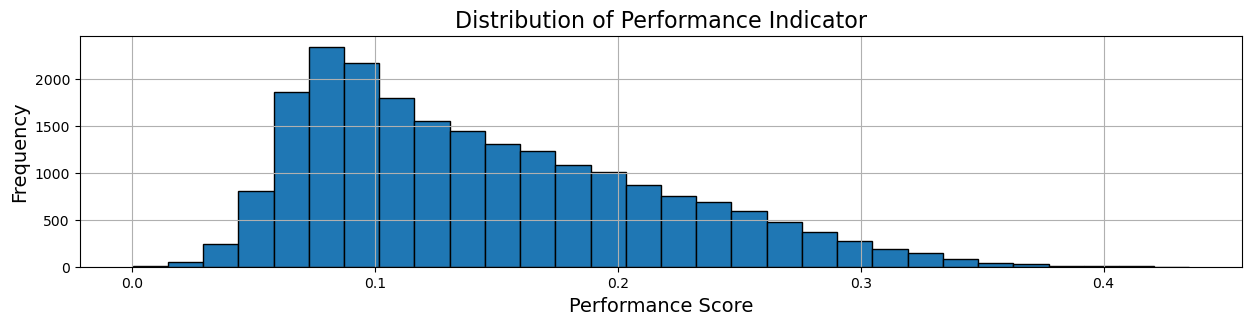

In [107]:
from sklearn.preprocessing import MinMaxScaler
# relevant fields and weights
fields = ["FG", "2PA", "3PA", "MP", "FT%", "TS%", "ORB%", "DRB%", "TRB%", "AST", "STL", "BLK"]
scaler = MinMaxScaler()
normalized_stats = scaler.fit_transform(seasons_stats[fields])
random_weights = np.random.rand(len(fields))
normalized_weights = random_weights / random_weights.sum()
performance_Score = np.dot(normalized_stats, normalized_weights)

seasons_stats["Performance_Score"] = performance_Score

# Plot
plt.figure(figsize=(15, 3))
plt.hist(performance_Score, bins=30, edgecolor='black')
plt.title("Distribution of Performance Indicator", fontsize=16)
plt.xlabel("Performance Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True)
# Top players
top_players = seasons_stats[["Player", "Performance_Score"]].sort_values(by="Performance_Score", ascending=False).head(7)
top_players

## 2.3 Hypothesis Tests

Examine the following hypothesis tests using the methods discussed in class, such as ANOVA, t-tests, A-B testing, Pearson and Spearman correlations. Make sure to provide p-values for each experiment and thoroughly justify your conclusions.

* Hypothesis 1: Player performance has significantly increased over time.

* Hypothesis 2: The average height and weight of NBA players has increased significantly over time.

* Hypothesis 3: Players from *Kentucky* college have a higher performance than players from other colleges.

* Hypothesis 4: There is a significant correlation between a player's height and their average points per game.

**What kind of testing should we choose:**
- **ANOVA** is used when comparing the means of three or more groups.
- **T-test** is used to compare the means of two groups.
- **A/B Testing** is a specific application of hypothesis testing to compare two variations, typically in marketing or product testing.
- **Pearson correlation** is used to assess the linear relationship between two continuous variables.
- **Spearman correlation** is used for monotonic relationships and can handle non-normal distributions.


### 2.3.1: Player performance has significantly increased over time.

#### 2.3.1.1: ANOVA

In [58]:
import scipy.stats as stats
seasons_stats231 = seasons_stats.dropna(subset=["Performance_Score"])
# Group performance scores by year
grouped_scores = [group["Performance_Score"].values for _, group in seasons_stats231.groupby("Year")]

# Perform one-way ANOVA
anova_result = stats.f_oneway(*grouped_scores)

print("ANOVA F-statistic:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)

ANOVA F-statistic: 7.128974549805578
ANOVA p-value: 3.1753972935816155e-40


**F-statistic**: 7.13  
**p-value**: 3.18e-40 (essentially 0)

- Interpretation
    Since the p-value is extremely low (far below a common alpha level like 0.05), you can **reject the null hypothesis**. This means there is strong evidence that **player performance has significantly changed over time**.
    
Let's see it below:


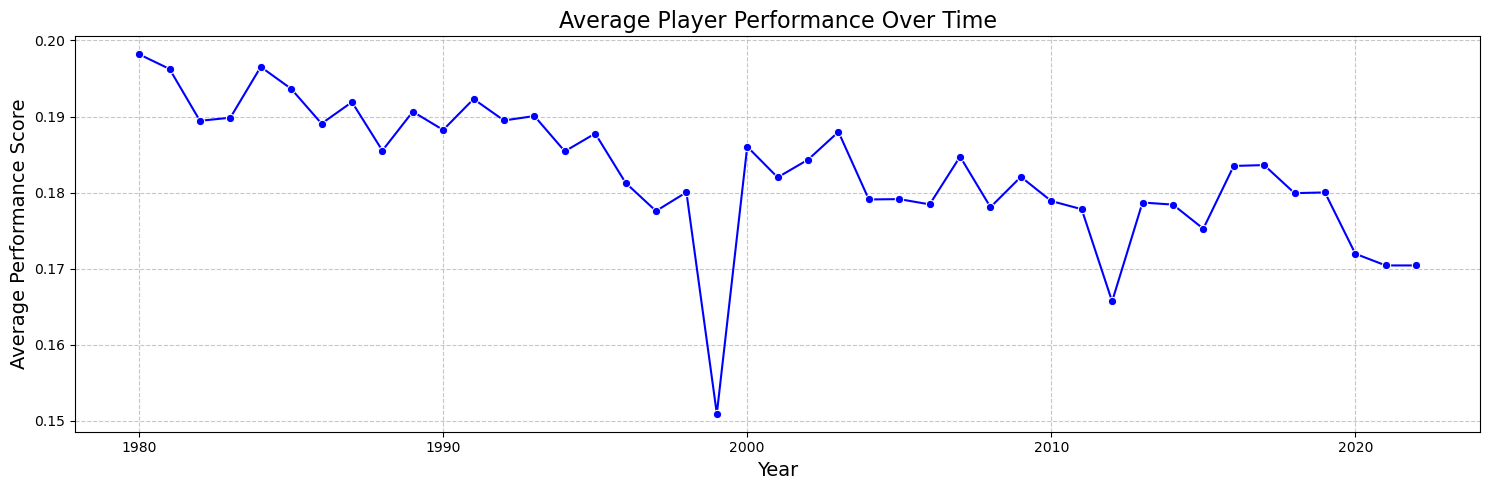

In [63]:
mean_performance_by_year = seasons_stats.groupby("Year")["Performance_Score"].mean()

# Create the line plot
plt.figure(figsize=(15, 5))
ss.lineplot(x=mean_performance_by_year.index, y=mean_performance_by_year.values, marker="o", color="blue")

# display
plt.title("Average Player Performance Over Time", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Performance Score", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 2.3.2: The average height and weight of NBA players has increased significantly over time.

#### 2.3.2.1: ANOVA

##### 2.3.2.1.1: Preprocess

In [ ]:
# Convert to numeric, setting non-numeric values to NaN
player_data['Ht'] = player_data['Ht'].str.replace('-', '.', regex=False)
player_data['Ht'] = pd.to_numeric(player_data['Ht'], errors='coerce')
player_data = player_data.dropna(subset=['Ht']) 
player_data['Ht'] = player_data['Ht'].astype(float)


In [97]:
# Create a DataFrame with rows for each year a player was active
compressed_data = []
for _, row in player_data.iterrows():
    for year in range(row['From'], row['To'] + 1):
        compressed_data.append({
            'Year': year,
            'Player': row['Player'],
            'Ht': row['Ht'],
            'Wt': row['Wt']
        })
compressed_data = pd.DataFrame(compressed_data)
# Group by year and calculate averages for height and weight
yearly_averages = compressed_data.groupby('Year').agg({
    'Ht': 'mean',
    'Wt': 'mean'
}).reset_index()
yearly_averages.rename(columns={'Ht': 'Average_Height', 'Wt': 'Average_Weight'}, inplace=True)
# Display the compressed data and averages
print("Expanded Data:")
print(compressed_data.head())

print("\nYearly Averages:")
print(yearly_averages.head())

Expanded Data:
   Year          Player   Ht     Wt
0  1991  Alaa Abdelnaby  6.1  240.0
1  1992  Alaa Abdelnaby  6.1  240.0
2  1993  Alaa Abdelnaby  6.1  240.0
3  1994  Alaa Abdelnaby  6.1  240.0
4  1995  Alaa Abdelnaby  6.1  240.0

Yearly Averages:
   Year  Average_Height  Average_Weight
0  1947        6.143913      189.007246
1  1948        6.161569      186.990196
2  1949        6.247160      190.994083
3  1950        6.238651      191.186047
4  1951        6.308671      194.566434


##### 2.3.2.1.2: Perfoming ANOVA 

In [99]:
height_groups = [group['Ht'].values for _, group in compressed_data.groupby('Year')]
weight_groups = [group['Wt'].values for _, group in compressed_data.groupby('Year')]

# Perform ANOVA for height and weight
anova_height = stats.f_oneway(*height_groups)
anova_weight = stats.f_oneway(*weight_groups)

# Display results
print("ANOVA for Height - F-statistic:", anova_height.statistic, ", p-value:", anova_height.pvalue)
print("ANOVA for Weight - F-statistic:", anova_weight.statistic, ", p-value:", anova_weight.pvalue)


ANOVA for Height - F-statistic: 7.124623746675616 , p-value: 1.6267879471484607e-69
ANOVA for Weight - F-statistic: 30.78663754428768 , p-value: 0.0


##### 2.3.2.1.3: Results

- Height
    - **F-statistic**: 7.12  
    - **p-value**: 1.63e-69 (extremely small)  
    - Interpretation: The **average height of NBA players has significantly changed over time**, as the p-value is far below the significance threshold (e.g., 0.05).

---

- Weight
    - **F-statistic**: 30.79  
    - **p-value**: ~0.0 (effectively zero)  
    - Interpretation: The **average weight of NBA players has significantly changed over time**, with an extremely small p-value indicating high confidence in this result.

---

- Conclusion
    Both height and weight trends are statistically significant over time. These findings suggest that changes in player height and weight are unlikely to be due to random chance and reflect meaningful shifts over the years.

---

- Visualizations:

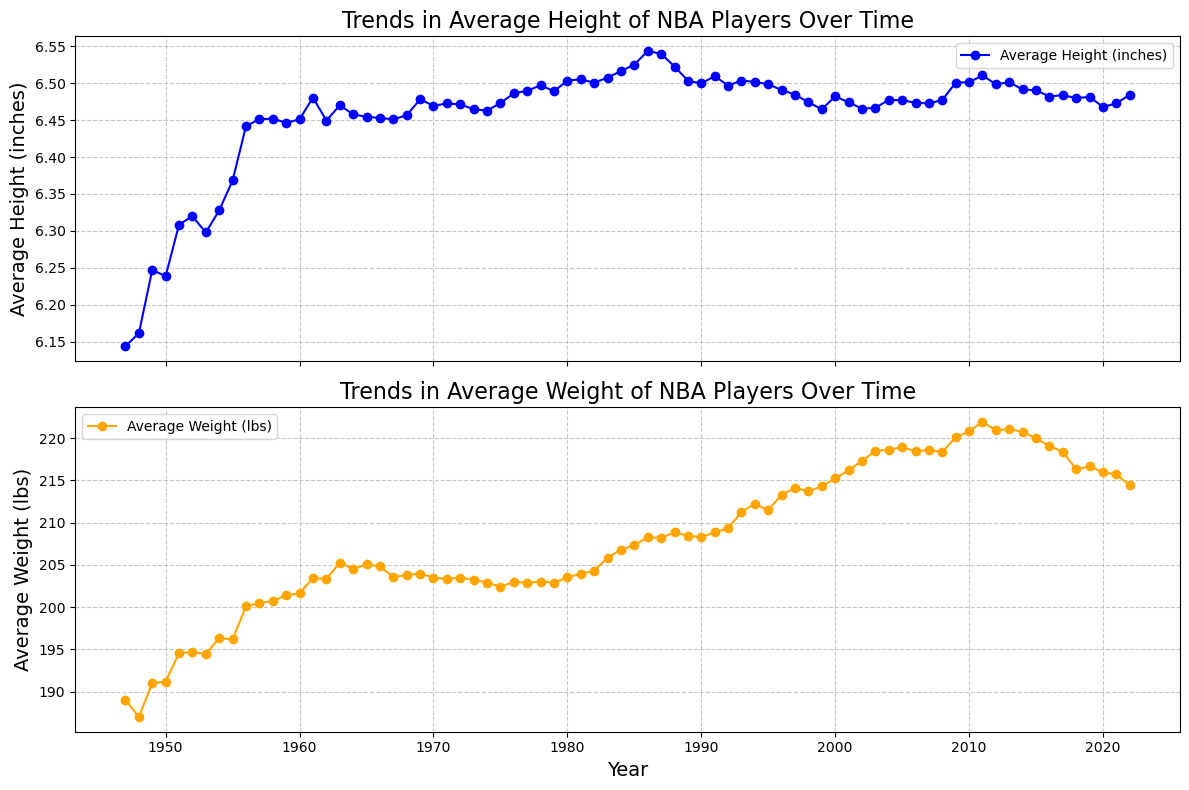

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
# Height
axes[0].plot(yearly_averages["Year"], yearly_averages["Average_Height"], label="Average Height (inches)", marker="o", color="blue")
axes[0].set_title("Trends in Average Height of NBA Players Over Time", fontsize=16)
axes[0].set_ylabel("Average Height (inches)", fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend()
# Weight
axes[1].plot(yearly_averages["Year"], yearly_averages["Average_Weight"], label="Average Weight (lbs)", marker="o", color="orange")
axes[1].set_title("Trends in Average Weight of NBA Players Over Time", fontsize=16)
axes[1].set_xlabel("Year", fontsize=14)
axes[1].set_ylabel("Average Weight (lbs)", fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend()
# Display
plt.tight_layout()
plt.show()

### 2.3.3: Players from *Kentucky* college have a higher performance than players from other colleges.

#### 2.3.3.1: A/B test

##### 2.3.3.1.1: Performing the test

In [112]:
merged_data = pd.merge(seasons_stats, player_data, on='Player', how = "inner")
merged_data = merged_data.dropna(subset='Performance_Score')
kentucky_group = merged_data[merged_data["Colleges"] == "Kentucky"]["Performance_Score"]
other_colleges_group = merged_data[merged_data["Colleges"] != "Kentucky"]["Performance_Score"]

# Perform a two-sample t-test
t_stat, p_value = stats.ttest_ind(kentucky_group, other_colleges_group, equal_var=False)

# Print the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 4.72494414396048
P-value: 2.8994723103436985e-06


##### 2.3.3.1.3: Results

**T-statistic**: 4.72  
**P-value**: 2.90e-06 (essentially 0)

- Interpretation

    - Since the **p-value is extremely small** (far below the common significance level of 0.05), we **reject the null hypothesis**.
    - This indicates that there is **a significant difference in performance** between players from *Kentucky* and players from other colleges.

---
- Conclusion

    - Players from *Kentucky* have a significantly different performance compared to players from other colleges, based on the test.


### 2.3.4: There is a significant correlation between a player's height and their average points per game.

#### 2.3.4.1: Preprocess

In [117]:
# Convert to numeric, setting non-numeric values to NaN
player_data['Ht'] = player_data['Ht'].str.replace('-', '.', regex=False)
player_data['Ht'] = pd.to_numeric(player_data['Ht'], errors='coerce')
player_data = player_data.dropna(subset=['Ht']) 
player_data['Ht'] = player_data['Ht'].astype(float)
# Merge on Player and Average
merged_data = pd.merge(seasons_stats, player_data[['Player', 'Ht']], on='Player')
merged_data['PTS_per_game'] = merged_data['PTS'] / merged_data['G']

#### 2.3.4.2: Pearson

In [119]:
pearson_corr, pearson_p_value = stats.pearsonr(merged_data['Ht'], merged_data['PTS_per_game'])
print("Pearson correlation coefficient:", pearson_corr)
print("Pearson p-value:", pearson_p_value)

Pearson correlation coefficient: 0.03886595777437095
Pearson p-value: 5.426545767533005e-10


#### 2.3.4.3: Spearman

In [120]:
spearman_corr, spearman_p_value = stats.spearmanr(merged_data['Ht'], merged_data['PTS_per_game'])
print("Spearman correlation coefficient:", spearman_corr)
print("Spearman p-value:", spearman_p_value)

Spearman correlation coefficient: 0.010149570868765482
Spearman p-value: 0.1052007872525715


#### 2.3.4.4: Results

**Spearman Correlation**
- **Spearman correlation coefficient**: 0.0101 (very close to 0)
- **Spearman p-value**: 0.1052

**Interpretation**:  
The Spearman correlation coefficient is very close to 0, indicating almost no rank correlation between height and points per game. Since the p-value is greater than 0.05, we **fail to reject the null hypothesis**, meaning there is no significant   rank correlation between player height and average points per game.

---

**Pearson Correlation**
- **Pearson correlation coefficient**: 0.0389 (very weak positive correlation)
- **Pearson p-value**: 5.43e-10 (very small, much less than 0.05)

**Interpretation**:  
Although the Pearson correlation coefficient is very small, suggesting a weak positive linear relationship, the **p-value is very small**, indicating that the correlation is statistically significant. However, the weak correlation means the practical relevance is minimal, even though it is statistically significant.

---

**Conclusion**
- The **Pearson correlation** shows a statistically significant but weak positive linear relationship between player height and average points per game.
- The **Spearman correlation** suggests no significant rank correlation, indicating no meaningful relationship when considering ranks.



c:\Users\HAMAHANG\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 600x500 with 0 Axes>

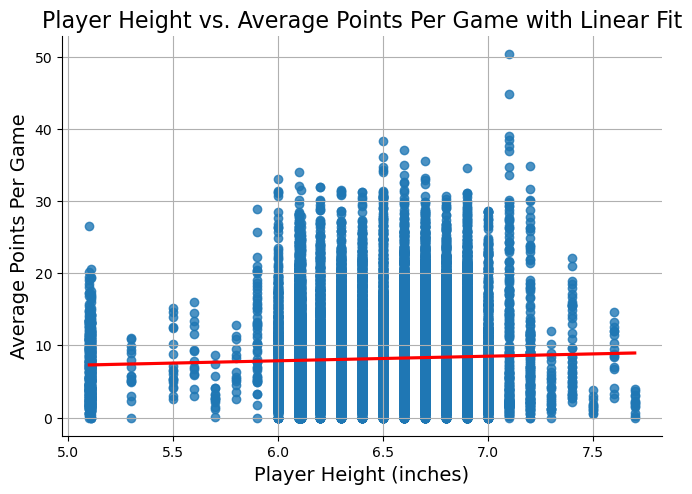

In [142]:
plt.figure(figsize=(6, 5))
ss.lmplot(x='Ht', y='PTS_per_game', data=merged_data, aspect=1.5, line_kws={'color': 'red'})
plt.title('Player Height vs. Average Points Per Game with Linear Fit', fontsize=16)
plt.xlabel('Player Height (inches)', fontsize=14)
plt.ylabel('Average Points Per Game', fontsize=14)
plt.grid(True)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()
